In [1]:
import json
from cv2 import resize
import numpy as np, matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import geometry
import pickle
from house import House
import PIL
import os
import pandas as pd
PIL.Image.MAX_IMAGE_PIXELS = None
with open('objects/camera_matrix1/houses.pickle', 'rb') as file:
    houses = pickle.load(file)
with open('objects/camera_matrix1/image_ids.pickle', 'rb') as file:
    image_ids = pickle.load(file)
houses[0].__dict__.keys()

dict_keys(['utm_coords', 'utm_edges', 'utm_mean', 'image_ids', 'image_coords', 'image_edges', 'id'])

In [2]:
ny, nx = 26460, 17004
header = ['ID', 'x', 'y', 'z', 'height2', 'rx', 'ry', 'rz',
          'pos1', 'pos2', 'pos3', 'att1', 'att2', 'att3', 'week', 'ToW', 'n_sat',
          'PDOP', 'lat', 'long', 'height']
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 - int(0.08*1e-3/4e-6), ny/2)) # image coordinatesaerial_photo = plt.imread(r'ims/aerial_photos/RGB/001.tif')
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 + int(0.08*1e-3/4e-6), ny/2)) # image coordinates

def make_data2(house, x_nudge=13, y_nudge=20, pad=15):

    dicts = []
    ims = []
    ap_ids = []
    for ind, ap_id in enumerate(house.image_ids):
        ap_ids.append(ap_id)
        print(ap_id, len(ap_ids))
        house_tr, edges_tr = house.image_coords[0], house.image_edges[0]
        aerial_photo = plt.imread(f'ims/aerial_photos/RGB/{(3 - len(str(ap_id+1)))*str(0) + str(ap_id+1)}.tif')
    

        house_tr = house_tr[ind]
        edges_tr = edges_tr[ind]
        xmin, ymin = np.min(house_tr, axis=1).astype(int) 
        xmax, ymax = np.max(house_tr, axis=1).astype(int)
        x_ext, y_ext = xmax-xmin, ymax-ymin
        if x_ext > y_ext:
            sq_pad = np.array((0, (x_ext-y_ext)/2)).astype(int)
        else:
            sq_pad = np.array(((y_ext-x_ext)/2, 0)).astype(int)


        
        im = aerial_photo[ymin-pad-sq_pad[1]:ymax+2*pad +sq_pad[1]+ y_nudge, xmin-pad - sq_pad[0]:xmax+2*pad + x_nudge+sq_pad[0]]
        x_ext, y_ext = im.shape[:2] 
        if x_ext != 0 and y_ext != 0:
            house_tr[0] = (house_tr[0]-xmin+pad+x_nudge + sq_pad[0])*256/x_ext
            house_tr[1] = (house_tr[1]-ymin+pad+y_nudge + sq_pad[1])*256/y_ext
            
            
            d_min = np.min(im.shape[:2])
            #ims.append(im[:d_min, :d_min])
            ims.append(resize(im[:d_min, :d_min], (256, 256)))
            out_dict = dict()
            for j, edge in enumerate(edges_tr):
                for k in range(edge.shape[1]):
                    edges_tr[j][0, k] += -xmin+pad+x_nudge + sq_pad[0]
                    edges_tr[j][1, k] += -ymin+pad+y_nudge + sq_pad[1]
                    edges_tr[j][0, k] *= 256/x_ext
                    edges_tr[j][1, k] *= 256/y_ext
                out_dict[tuple(np.round(house_tr[:, j], 8))] = np.round(np.array(edge).swapaxes(1, 0), 8)
            dicts.append(out_dict)
                        
    return dicts, ims, ap_ids

def viz(house, im, ax):
    ax.imshow(im)
    for corner, edges in house.items():
        for edge in edges:
            ax.plot([corner[0], edge[0]], [corner[1], edge[1]], c='coral', zorder=0)
        ax.scatter(*corner, c='cornflowerblue', s=7, zorder=1)


In [25]:
house_id = 16618
for i, house in enumerate(houses):
    if house.id==house_id:
        print(i)


852


In [26]:
ind = 852
house = houses[ind]
dicts, ims, im_ids = make_data2(house)

93 1
94 2
95 3
96 4
97 5


In [20]:
dicts, ims, im_ids = dicts[:5], ims[:5], im_ids[:5]

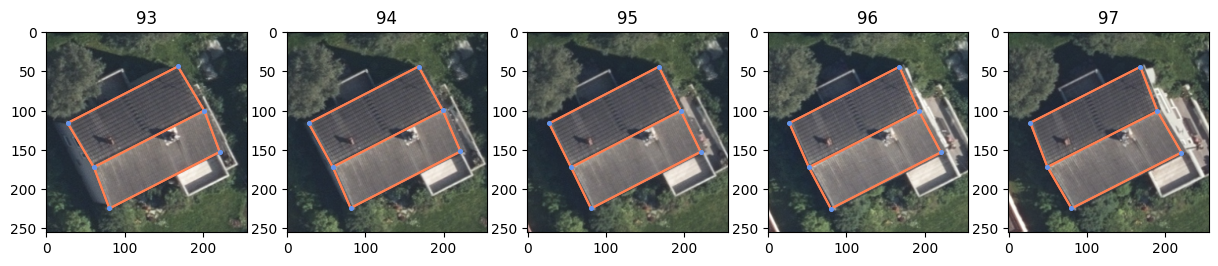

In [27]:
if len(dicts)==5:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))    
else:
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
for i, ax in enumerate(axs.flatten()):
    #ax.axis('off')
    ax.set_title(im_ids[i])
    viz(dicts[i], ims[i], ax)

In [28]:
path = 'test_output/reproject_set/{}'.format(house_id)
det_path = path + '/det'
rgb_path = path + '/rgb'
annot_path = path + '/annot'
fig_path = path + '/figures'
os.mkdir(path)
os.mkdir(det_path)
os.mkdir(rgb_path)
os.mkdir(annot_path)
os.mkdir(fig_path)

with open (path + '/test_list.txt', 'w') as  file:
    for id  in im_ids:
        id = str(id)
        file.write(id +'\n')


for i in range(len(dicts)):
    filename = str(im_ids[i])
    out_im = PIL.Image.fromarray(ims[i])
    out_im.save(rgb_path + '/{}.jpg'.format(filename))

    np.save(det_path +'/'+ filename, np.array(list(dicts[i].keys())))
    np.save(annot_path +'/'+ filename, dicts[i])

with open('objects/camera_matrix1/houses.pickle', 'rb') as file:
    houses = pickle.load(file)
    
with open(path + '/house.pickle', 'wb') as file:
    pickle.dump(houses[ind], file)
print(house_id)
 

16618
